Credits to Elissaios Sarmas for the model training and transfer learning code, which was adapted for use on this dataset. Code can be found here: https://github.com/ElissaiosSarmas/Transfer-learning-strategies-for-solar-power-forecasting-under-data-scarcity

In [22]:
# Clear any logs from previous runs
!rm -r ./LSTM/logs

'rm' is not recognized as an internal or external command,
operable program or batch file.


I will use a dataset obtained from Kaggle (credits to Afroz) that has 8760 entries and contains hourly PV output to train the base model.

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import tensorflow as tf
import datetime, os
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras_layer_normalization import LayerNormalization
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow import keras
import time
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from hyperopt import fmin, tpe, hp, partial, Trials, STATUS_OK, STATUS_FAIL, space_eval
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras import layers

from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score 
from sklearn import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from math import sqrt
from sklearn.metrics import mean_squared_error, zero_one_loss,mean_absolute_error,r2_score
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [24]:
path = "C:/work/Honours code/Datasets/Kaggle-Solar-PV-data/Solar Power Plant Data.csv"

p0 = pd.read_csv(path, header=0)

In [25]:
p0_copy = p0.copy()
p0_copy['timestamp'] = pd.to_datetime(p0['Date-Hour(NMT)'], format='%d.%m.%Y-%H:%M')

p0_copy.drop(['Date-Hour(NMT)'], axis=1, inplace=True)

timestamp = p0_copy.pop('timestamp')
p0_copy.insert(0, 'timestamp', timestamp)
p0_copy['hour'] = pd.to_datetime(p0_copy['timestamp']).dt.hour
p0_copy['month'] = pd.to_datetime(p0_copy['timestamp']).dt.month

In [26]:
p0_copy.head()

,timestamp,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction,hour,month
0,2017-01-01 00:00:00,0.6,0,1003.8,-7.4,0.1,97,0.0,0,1
1,2017-01-01 01:00:00,1.7,0,1003.5,-7.4,-0.2,98,0.0,1,1
2,2017-01-01 02:00:00,0.6,0,1003.4,-6.7,-1.2,99,0.0,2,1
3,2017-01-01 03:00:00,2.4,0,1003.3,-7.2,-1.3,99,0.0,3,1
4,2017-01-01 04:00:00,4.0,0,1003.1,-6.3,3.6,67,0.0,4,1


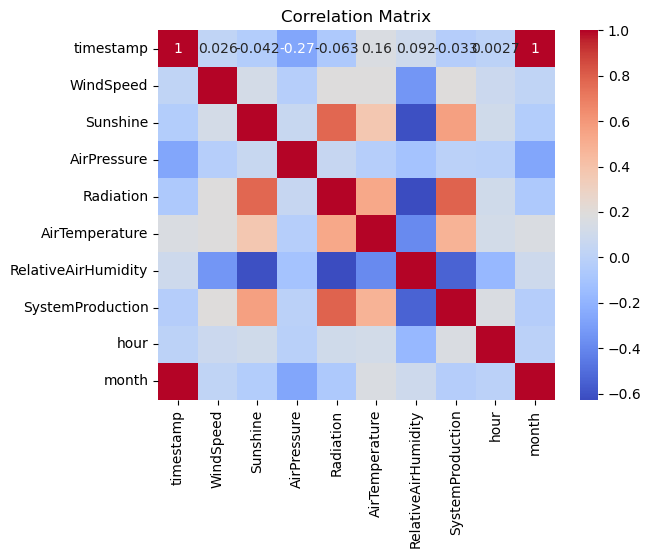

In [27]:
corr_matrix = p0_copy.corr()
# Plot the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [28]:

# Perform One-Hot-Encoding for Months and Sin-Cos Similarities for Hours
data = p0_copy
data['timestamp'] = pd.to_numeric(data['timestamp'])
data = pd.get_dummies(data, columns=['month'])
data.loc[:,'sin_hour'] = np.sin(2*np.pi*data['timestamp']/24)
data.loc[:,'cos_hour'] = np.cos(2*np.pi*data['timestamp']/24)

print("Total Dataset =", len(data))

Total Dataset = 8760


In [29]:
# Shaping data for LSTM input
def split_sequences(sequences, n_steps, n_outputs, only_production, validation_split):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern 
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix + n_outputs > len(sequences):
            break
        # gather input and output parts of the pattern
        if only_production==True:
            seq_x, seq_y = sequences[i:end_ix, -1], sequences[end_ix:(end_ix+n_outputs), -1]
        else:
            seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:(end_ix+n_outputs), -1]
            
        X.append(seq_x)
        y.append(seq_y)
    
    # Convert to numpy arrays
    X, y = np.array(X), np.array(y)
    
    # Split the data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, random_state=42)
    
    return x_train, x_val, y_train, y_val

In [30]:
def unique_shapes(x, y, lag_, n_features_, num_of_outputs_, only_production, validation_split):
    unique_shapes = []
    for k in range(len(x)):
        if only_production==True:
            if (x[k].shape == (lag,)) & (y[k].shape == (num_of_outputs_,)):
                unique_shapes.append(k)
        else:
            if (x[k].shape == (lag_, n_features_)) & (y[k].shape == (num_of_outputs_,)):
                unique_shapes.append(k)       
    x = x[unique_shapes]
    y = y[unique_shapes]
    x = np.stack(x)
    y = np.stack(y)
    
    # Split the data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=validation_split, random_state=42)
    
    return x_train, x_val, y_train, y_val

In [31]:
# Select the columns that you want to use as features
cols = [
    "timestamp",
    "WindSpeed",
    "Sunshine",
    "AirPressure",
    "Radiation",
    "AirTemperature",
    "RelativeAirHumidity",
    "sin_hour",
    "cos_hour",
    "SystemProduction",
    ]
# Set to True if using only the production, else to False
only_production = False
# Splitting factor for training set and test set
split = 0.4

# Select the lag variable, the number of features (must be same with cols selected) and the horizon
lag = 5
n_features = len(cols)
num_of_outputs = 1

In [32]:
# Scale data seperately
from sklearn.preprocessing import MinMaxScaler

if only_production == True:
    data_ = data_['SystemProduction']
    train = data_.iloc[:int(len(data_)*split_),]
    test = data_.iloc[int(len(data_)*split_):,]
    scaler = MinMaxScaler(feature_range=(0, 1))
    train = scaler.fit_transform(train.values.reshape(-1, 1))
    test = scaler.fit_transform(test.values.reshape(-1, 1))
else:
    data = data[cols]
    train = data.iloc[:int(len(data)*split),:]
    test = data.iloc[int(len(data)*split):,]
    scaler = MinMaxScaler(feature_range=(0,1))
    train = scaler.fit_transform(train)
    test = scaler.fit_transform(test)

In [33]:
# Create the input for LSTM: x(batch_size, lag, features), y(batch_size,)

x_train, x_val, y_train, y_val = split_sequences(train, n_steps=lag, n_outputs=num_of_outputs, only_production=only_production, validation_split=split)
x_test, x_val, y_test, y_val = split_sequences(test, n_steps=lag, n_outputs=num_of_outputs, only_production=only_production, validation_split=split)

x_train, x_val, y_train, y_val = unique_shapes(x_train, y_train, lag, n_features, num_of_outputs, only_production=only_production, validation_split=split)
x_test, x_val, y_test, y_val = unique_shapes(x_test, y_test, lag, n_features, num_of_outputs, only_production=only_production, validation_split=split)

# Reshape for only_production case
if only_production:
    x_train = x_train.reshape((x_train.shape[0], lag, 1))
    x_test = x_test.reshape((x_test.shape[0], lag, 1))
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2])
# Print the shapes
print("Size of Train / Test =", x_train.shape, y_train.shape, x_test.shape, y_test.shape)


Size of Train / Test = (1259, 5, 10) (1259, 1) (1890, 5, 10) (1890, 1)


In [34]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred))))

def createModel():

    # LSTM Model Architecture

    optimizer = Adam(learning_rate=0.002, clipvalue=0.5)
    model = Sequential()
    model.add(Bidirectional(LSTM(32,
                                 activation="relu",
                                 return_sequences=True),
                                input_shape=(x_train.shape[1], x_train.shape[2]), name = 'bidirectional_1'))
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(128,activation="relu",return_sequences=True), name = 'bidirectional_2'))
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(256,activation="relu",return_sequences=False), name = 'bidirectional_3'))
    model.add(Dense(1, name='output_layer'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    # renaming weight handles to ensure uniqueness
    # credits to Nour Alden
    # from https://stackoverflow.com/questions/72776335/valueerror-unable-to-create-dataset-name-already-exists-when-using-modelcheck

    for i in range(len(model.weights)):
        model.weights[i]._handle_name = model.weights[i].name + "_" + str(i)

    model.summary()
    return model

In [35]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import TFSMLayer
import h5py
import os
import time
timestamp = int(time.time())
true_values = []
predicted_values = []
#model_path = "C:/work/Honours code/Transfer learning/LSTM/model/LSTM_base.h5"
model_path = "LSTM_base.h5"
def fit_predict_stats(model):
    # Early stopping property
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    tb = TensorBoard(log_dir='logs')
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    history = model.fit(x_train, y_train, epochs=100, validation_split=0.14, batch_size=32, verbose=1, shuffle=True, callbacks=[tensorboard_callback, es]).history
   
    
    if os.path.exists(model_path):
        
    # Load the model
        tf.debugging.set_log_device_placement(True)
        model = load_model(model_path)
    else:
        # Model file does not exist, so save the model
        
        # Fit the model
        model.save(model_path, overwrite=True)



    # summarize history for MAE and MSE
    # plt.plot(history['loss'])
    # plt.plot(history['val_loss'])
    # plt.title('model loss')
    # plt.ylabel('Model MSE')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'val'], loc='upper left')

    # plt.figure()
    # plt.plot(history['mae'])
    # plt.plot(history['val_mae'])
    # plt.title('Model MAE')
    # plt.ylabel('MAE')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'val'], loc='upper left')

    # Metrics on scaled data
    
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    y_pred = model.predict(x_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    mae = mean_absolute_error(y_train, y_pred)
    # print('Train Scaled RMSE: {}'.format(rmse))
    # print('Train Scaled MAE: {}'.format(mae))
    # print('Train Scaled R2 Score: ', r2_score(y_train, y_pred)*100)

    y_pred = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    # print('Test Scaled RMSE: {}'.format(rmse))
    # print('Test Scaled MAE: {}'.format(mae))
    # print('Test Scaled R2 Score: ',r2_score(y_test, y_pred)*100)


    
    # Metrics on original data
    true = []
    hat = []
    range_ = [0]
    # range_ = list(range(6))

    for i,j in zip([[x_train,y_train],[x_test,y_test]],['Train','Test']):
        # make a prediction
        yhat = model.predict(i[0])
        if yhat.shape == (yhat.shape[0],):
            yhat = yhat.reshape((yhat.shape[0],1))  
      
        y_hat = []
        for k in range(len(yhat)):
            if k == 0:
                for l in range_:
                    y_hat.append(yhat[k,l])
            else:
                y_hat.append(yhat[k,-1])
        
        y_hat = np.stack(y_hat)
        y_hat = y_hat.reshape((y_hat.shape[0],1))
        
        i[0] = i[0].reshape((i[0].shape[0],lag,n_features))
        
        x_hat = []
        for k in range(len(i[0])):
            if k == 0:
                x_hat.append(i[0][k])
            elif k!= 0:
                x_hat.append(i[0][k][-1,:])
        
        x_hat = np.vstack(x_hat)
        
        initial_x_hat_shape = x_hat.shape[0]
        initial_y_hat_shape = y_hat.shape[0]
        
        # print(x_hat.shape)
        # print(y_hat.shape)
        
        if x_hat.shape[0]-y_hat.shape[0] != 0.0:
            if x_hat.shape[0] > y_hat.shape[0]:
                for k in range(x_hat.shape[0]-y_hat.shape[0]):
                    y_hat = np.insert(y_hat, 0, y_hat[0,0], axis=0)
                    added_values = True
            elif x_hat.shape[0] < y_hat.shape[0]:
                y_hat = y_hat[-int(x_hat.shape[0]-y_hat.shape[0]):,:]
                added_values = False
        
        # print(x_hat.shape)
        # print(y_hat.shape)
        
        # invert scaling for forecast
        if only_production==True:
            inv_yhat = np.concatenate((x_hat[:,:-1],y_hat), axis=1)
            inv_yhat = scaler.inverse_transform(inv_yhat)
        else:    
            inv_yhat = np.concatenate((x_hat[:,:-1],y_hat), axis=1)
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            
        # invert scaling for actual
        y_true = []
        for k in range(len(i[1])):
            if k ==0:
                for l in range_:
                    y_true.append(i[1][k,l])
            else:
                y_true.append(i[1][k,-1])

        y_true = np.stack(y_true)
        y_true = y_true.reshape((y_true.shape[0],1))
        print(y_true.shape)

        initial_y_true_shape = y_true.shape[0]
        
        if x_hat.shape[0]-y_true.shape[0] != 0.0:
            if x_hat.shape[0] > y_true.shape[0]:
                for k in range(x_hat.shape[0]-y_true.shape[0]):
                    y_true = np.insert(y_true, 0, y_true[0,0], axis=0)
                    added_values = True
            elif x_hat.shape[0] < y_true.shape[0]:
                y_true = y_true[-int(x_hat.shape[0]-y_true.shape[0]):,:]
                added_values = False
                
        if only_production==True:
            inv_y = np.concatenate((x_hat[:,:-1],y_true), axis=1)
            inv_y = scaler.inverse_transform(inv_y)
        else:
            inv_y = np.concatenate((x_hat[:,:-1],y_true), axis=1)
            inv_y = scaler.inverse_transform(inv_y)
            inv_y = inv_y[:,-1]
        
        true.append(inv_y)
        hat.append(inv_yhat)

        # true_values.append(true)
        # predicted_values.append(hat)
        
        # calculate RMSE
        rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate MAE
        mae = mean_absolute_error(inv_y, inv_yhat)
        print('Test MAE: %.3f' % mae)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print('Test R2 Score: ',r2)
        # Calculate MAPE
        mape = mean_absolute_percentage_error(inv_y, inv_yhat)
        print('MAPE', mape)
        # Calculate MBE
        mbe = np.mean(inv_yhat - inv_y)
        print('Test MBE', mbe)
        # Calculate nRMSE
        nRMSE = rmse / np.mean(inv_y)
        print('nRMSE', nRMSE)

        



    mae_list.append(mae)
    rmse_list.append(rmse)
    r_square_list.append(r2)
    mape_list.append(mape)
    mbe_list.append(mbe)
    nRMSE_list.append(nRMSE)



In [36]:
mae_list = []
rmse_list = []
r_square_list = []
mape_list = []
mbe_list = []
nRMSE_list = []
num_iterations = 20
#num_iterations = 2
for i in range(num_iterations):
    # print("Shape of x_train:", x_train.shape)
    # print("Shape of y_train:", y_train.shape)
    # print("Shape of x_test:", x_test.shape)
    # print("Shape of y_test:", y_test.shape)
    model = createModel()
    keras.config.disable_traceback_filtering()
    fit_predict_stats(model)

# sns.set_style("darkgrid")
# for true, hat in zip(true_values, predicted_values):
#     plt.figure()
#     plt.plot(true[1], color="green")
#     plt.plot(hat[1], color="red")
#     plt.savefig('plots/lstm_base_plot.png')
    #plt.show()

print("MAE:", mae_list)
print("RMSE:", rmse_list)
print("R^2:", r_square_list)
print("MAPE:", mape_list)
print("MBE:", mbe_list)
print("nRMSE:", nRMSE_list)

print("Mean MAE:", np.mean(mae_list))
print("Mean RMSE:", np.mean(rmse_list))
print("Mean R^2:", np.mean(r_square_list))
print("Mean MAPE:", np.mean(mape_list))
print("Mean MBE:", np.mean(mbe_list))
print("Mean nRMSE:", np.mean(nRMSE_list))


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - loss: 0.0300 - mae: 0.1021 - val_loss: 0.0195 - val_mae: 0.0780
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0199 - mae: 0.0736 - val_loss: 0.0143 - val_mae: 0.0553
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0164 - mae: 0.0656 - val_loss: 0.0124 - val_mae: 0.0451
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0105 - mae: 0.0482 - val_loss: 0.0101 - val_mae: 0.0442
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0118 - mae: 0.0507 - val_loss: 0.0105 - val_mae: 0.0472
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0110 - mae: 0.0523 - val_loss: 0.0093 - val_mae: 0.0370
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0083 - mae: 0.0390 - val_loss: 0.0088 - val_mae: 0.0390
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0067 - mae: 0.0369 - val_loss: 0.0085 - val_mae: 0.0429
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1259, 1)
Test RMSE: 550.024
Test MAE: 234.585
Test R2 Score:  0.8538045230151938
MAPE 0.6562217414765625
Test MBE 21.47796156200784
nRMSE 0.9458405905850958
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
(1890, 1)
Test RMSE: 619.953
Test MAE: 297.222
Test R2 Score:  0.8390889839962017
MAPE 0.5332206350431351
Test MBE -61.80355965005809
nRMSE 0.8017083446187029


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - loss: 0.0282 - mae: 0.0977 - val_loss: 0.0231 - val_mae: 0.0765
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0189 - mae: 0.0735 - val_loss: 0.0151 - val_mae: 0.0540
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0154 - mae: 0.0607 - val_loss: 0.0125 - val_mae: 0.0467
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0122 - mae: 0.0532 - val_loss: 0.0160 - val_mae: 0.0534
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0161 - mae: 0.0561 - val_loss: 0.0153 - val_mae: 0.0620
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0100 - mae: 0.0484 - val_loss: 0.0090 - val_mae: 0.0421
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0111 - mae: 0.0489 - val_loss: 0.0106 - val_mae: 0.0501
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0079 - mae: 0.0436 - val_loss: 0.0118 - val_mae: 0.0548
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
(1259, 1)
Test RMSE: 550.024
Test MAE: 234.585
Test R2 Score:  0.8538045230151938
MAPE 0.6562217414765625
Test MBE 21.47796156200784
nRMSE 0.9458405905850958
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
(1890, 1)
Test RMSE: 619.953
Test MAE: 297.222
Test R2 Score:  0.8390889839962017
MAPE 0.5332206350431351
Test MBE -61.80355965005809
nRMSE 0.8017083446187029


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - loss: 0.0307 - mae: 0.1045 - val_loss: 0.0189 - val_mae: 0.0654
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0197 - mae: 0.0710 - val_loss: 0.0157 - val_mae: 0.0602
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0167 - mae: 0.0618 - val_loss: 0.0119 - val_mae: 0.0520
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0145 - mae: 0.0625 - val_loss: 0.0111 - val_mae: 0.0502
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0117 - mae: 0.0508 - val_loss: 0.0103 - val_mae: 0.0499
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0088 - mae: 0.0458 - val_loss: 0.0091 - val_mae: 0.0486
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0107 - mae: 0.0503 - val_loss: 0.0098 - val_mae: 0.0424
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0091 - mae: 0.0452 - val_loss: 0.0093 - val_mae: 0.0368
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
(1259, 1)
Test RMSE: 550.024
Test MAE: 234.585
Test R2 Score:  0.8538045230151938
MAPE 0.6562217414765625
Test MBE 21.47796156200784
nRMSE 0.9458405905850958
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(1890, 1)
Test RMSE: 619.953
Test MAE: 297.222
Test R2 Score:  0.8390889839962017
MAPE 0.5332206350431351
Test MBE -61.80355965005809
nRMSE 0.8017083446187029


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - loss: 0.0297 - mae: 0.0989 - val_loss: 0.0223 - val_mae: 0.1065
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0210 - mae: 0.0898 - val_loss: 0.0202 - val_mae: 0.0650
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0170 - mae: 0.0676 - val_loss: 0.0139 - val_mae: 0.0601
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0144 - mae: 0.0580 - val_loss: 0.0116 - val_mae: 0.0571
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0097 - mae: 0.0463 - val_loss: 0.0109 - val_mae: 0.0446
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0124 - mae: 0.0550 - val_loss: 0.0106 - val_mae: 0.0439
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0081 - mae: 0.0422 - val_loss: 0.0115 - val_mae: 0.0463
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0090 - mae: 0.0443 - val_loss: 0.0084 - val_mae: 0.0383
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
(1259, 1)
Test RMSE: 550.024
Test MAE: 234.585
Test R2 Score:  0.8538045230151938
MAPE 0.6562217414765625
Test MBE 21.47796156200784
nRMSE 0.9458405905850958
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
(1890, 1)
Test RMSE: 619.953
Test MAE: 297.222
Test R2 Score:  0.8390889839962017
MAPE 0.5332206350431351
Test MBE -61.80355965005809
nRMSE 0.8017083446187029


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - loss: 0.0321 - mae: 0.1055 - val_loss: 0.0205 - val_mae: 0.0772
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0196 - mae: 0.0783 - val_loss: 0.0184 - val_mae: 0.0660
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0139 - mae: 0.0576 - val_loss: 0.0094 - val_mae: 0.0470
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0161 - mae: 0.0664 - val_loss: 0.0185 - val_mae: 0.0712
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0147 - mae: 0.0598 - val_loss: 0.0178 - val_mae: 0.0732
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0111 - mae: 0.0588 - val_loss: 0.0097 - val_mae: 0.0444
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0080 - mae: 0.0442 - val_loss: 0.0088 - val_mae: 0.0390
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0074 - mae: 0.0389 - val_loss: 0.0086 - val_mae: 0.0402
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step 

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(1259, 1)
Test RMSE: 550.024
Test MAE: 234.585
Test R2 Score:  0.8538045230151938
MAPE 0.6562217414765625
Test MBE 21.47796156200784
nRMSE 0.9458405905850958
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
(1890, 1)
Test RMSE: 619.953
Test MAE: 297.222
Test R2 Score:  0.8390889839962017
MAPE 0.5332206350431351
Test MBE -61.80355965005809
nRMSE 0.8017083446187029


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 148ms/step - loss: 0.0352 - mae: 0.1093 - val_loss: 0.0203 - val_mae: 0.0743
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0281 - mae: 0.0832 - val_loss: 0.0207 - val_mae: 0.0718
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0201 - mae: 0.0729 - val_loss: 0.0164 - val_mae: 0.0572
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0140 - mae: 0.0613 - val_loss: 0.0114 - val_mae: 0.0511
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.0103 - mae: 0.0503 - val_loss: 0.0100 - val_mae: 0.0411
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0104 - mae: 0.0484 - val_loss: 0.0152 - val_mae: 0.0658
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0125 - mae: 0.0554 - val_loss: 0.0092 - val_mae: 0.0400
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0080 - mae: 0.0403 - val_loss: 0.0105 - val_mae: 0.0540
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/ste

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(1259, 1)
Test RMSE: 550.024
Test MAE: 234.585
Test R2 Score:  0.8538045230151938
MAPE 0.6562217414765625
Test MBE 21.47796156200784
nRMSE 0.9458405905850958
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
(1890, 1)
Test RMSE: 619.953
Test MAE: 297.222
Test R2 Score:  0.8390889839962017
MAPE 0.5332206350431351
Test MBE -61.80355965005809
nRMSE 0.8017083446187029


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - loss: 0.0314 - mae: 0.1012 - val_loss: 0.0201 - val_mae: 0.0695
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0213 - mae: 0.0771 - val_loss: 0.0174 - val_mae: 0.0621
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0147 - mae: 0.0646 - val_loss: 0.0146 - val_mae: 0.0494
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0121 - mae: 0.0537 - val_loss: 0.0106 - val_mae: 0.0481
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.0121 - mae: 0.0537 - val_loss: 0.0109 - val_mae: 0.0474
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0088 - mae: 0.0462 - val_loss: 0.0073 - val_mae: 0.0468
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0082 - mae: 0.0460 - val_loss: 0.0083 - val_mae: 0.0378
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0082 - mae: 0.0428 - val_loss: 0.0076 - val_mae: 0.0334
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/st

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(1259, 1)
Test RMSE: 550.024
Test MAE: 234.585
Test R2 Score:  0.8538045230151938
MAPE 0.6562217414765625
Test MBE 21.47796156200784
nRMSE 0.9458405905850958
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
(1890, 1)
Test RMSE: 619.953
Test MAE: 297.222
Test R2 Score:  0.8390889839962017
MAPE 0.5332206350431351
Test MBE -61.80355965005809
nRMSE 0.8017083446187029


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 169ms/step - loss: 0.0291 - mae: 0.0984 - val_loss: 0.0209 - val_mae: 0.0767
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0247 - mae: 0.0874 - val_loss: 0.0162 - val_mae: 0.0606
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.0142 - mae: 0.0554 - val_loss: 0.0173 - val_mae: 0.0539
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.0133 - mae: 0.0542 - val_loss: 0.0133 - val_mae: 0.0614
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0104 - mae: 0.0532 - val_loss: 0.0099 - val_mae: 0.0477
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0095 - mae: 0.0479 - val_loss: 0.0091 - val_mae: 0.0437
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.0089 - mae: 0.0467 - val_loss: 0.0096 - val_mae: 0.0432
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0076 - mae: 0.0419 - val_loss: 0.0083 - val_mae: 0.0443
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/st

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
(1259, 1)
Test RMSE: 550.024
Test MAE: 234.585
Test R2 Score:  0.8538045230151938
MAPE 0.6562217414765625
Test MBE 21.47796156200784
nRMSE 0.9458405905850958
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
(1890, 1)
Test RMSE: 619.953
Test MAE: 297.222
Test R2 Score:  0.8390889839962017
MAPE 0.5332206350431351
Test MBE -61.80355965005809
nRMSE 0.8017083446187029


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 152ms/step - loss: 0.0330 - mae: 0.1093 - val_loss: 0.0198 - val_mae: 0.0685
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0172 - mae: 0.0662 - val_loss: 0.0132 - val_mae: 0.0577
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0129 - mae: 0.0556 - val_loss: 0.0138 - val_mae: 0.0575
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.0091 - mae: 0.0446 - val_loss: 0.0121 - val_mae: 0.0516
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0110 - mae: 0.0558 - val_loss: 0.0098 - val_mae: 0.0402
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.0092 - mae: 0.0438 - val_loss: 0.0141 - val_mae: 0.0522
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0102 - mae: 0.0484 - val_loss: 0.0091 - val_mae: 0.0448
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0079 - mae: 0.0430 - val_loss: 0.0099 - val_mae: 0.0426
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
(1259, 1)
Test RMSE: 550.024
Test MAE: 234.585
Test R2 Score:  0.8538045230151938
MAPE 0.6562217414765625
Test MBE 21.47796156200784
nRMSE 0.9458405905850958
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1890, 1)
Test RMSE: 619.953
Test MAE: 297.222
Test R2 Score:  0.8390889839962017
MAPE 0.5332206350431351
Test MBE -61.80355965005809
nRMSE 0.8017083446187029


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - loss: 0.0321 - mae: 0.1009 - val_loss: 0.0221 - val_mae: 0.0676
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0181 - mae: 0.0673 - val_loss: 0.0148 - val_mae: 0.0633
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0151 - mae: 0.0619 - val_loss: 0.0135 - val_mae: 0.0547
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0123 - mae: 0.0594 - val_loss: 0.0106 - val_mae: 0.0430
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0088 - mae: 0.0414 - val_loss: 0.0081 - val_mae: 0.0378
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0083 - mae: 0.0447 - val_loss: 0.0087 - val_mae: 0.0435
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0101 - mae: 0.0487 - val_loss: 0.0099 - val_mae: 0.0432
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0104 - mae: 0.0456 - val_loss: 0.0091 - val_mae: 0.0398
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(1259, 1)
Test RMSE: 550.024
Test MAE: 234.585
Test R2 Score:  0.8538045230151938
MAPE 0.6562217414765625
Test MBE 21.47796156200784
nRMSE 0.9458405905850958
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
(1890, 1)
Test RMSE: 619.953
Test MAE: 297.222
Test R2 Score:  0.8390889839962017
MAPE 0.5332206350431351
Test MBE -61.80355965005809
nRMSE 0.8017083446187029


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - loss: 0.0293 - mae: 0.0983 - val_loss: 0.0210 - val_mae: 0.0683
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0194 - mae: 0.0725 - val_loss: 0.0162 - val_mae: 0.0558
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0137 - mae: 0.0551 - val_loss: 0.0110 - val_mae: 0.0484
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0119 - mae: 0.0528 - val_loss: 0.0133 - val_mae: 0.0487
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0124 - mae: 0.0514 - val_loss: 0.0101 - val_mae: 0.0431
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0093 - mae: 0.0465 - val_loss: 0.0152 - val_mae: 0.0593
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0115 - mae: 0.0509 - val_loss: 0.0125 - val_mae: 0.0501
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0072 - mae: 0.0417 - val_loss: 0.0084 - val_mae: 0.0396
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(1259, 1)
Test RMSE: 550.024
Test MAE: 234.585
Test R2 Score:  0.8538045230151938
MAPE 0.6562217414765625
Test MBE 21.47796156200784
nRMSE 0.9458405905850958
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1890, 1)
Test RMSE: 619.953
Test MAE: 297.222
Test R2 Score:  0.8390889839962017
MAPE 0.5332206350431351
Test MBE -61.80355965005809
nRMSE 0.8017083446187029


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - loss: 0.0355 - mae: 0.1129 - val_loss: 0.0200 - val_mae: 0.0674
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0212 - mae: 0.0731 - val_loss: 0.0174 - val_mae: 0.0596
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0173 - mae: 0.0603 - val_loss: 0.0110 - val_mae: 0.0467
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0121 - mae: 0.0527 - val_loss: 0.0091 - val_mae: 0.0431
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0090 - mae: 0.0443 - val_loss: 0.0109 - val_mae: 0.0472
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0105 - mae: 0.0488 - val_loss: 0.0104 - val_mae: 0.0436
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0088 - mae: 0.0438 - val_loss: 0.0091 - val_mae: 0.0451
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0072 - mae: 0.0406 - val_loss: 0.0100 - val_mae: 0.0402
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1259, 1)
Test RMSE: 550.024
Test MAE: 234.585
Test R2 Score:  0.8538045230151938
MAPE 0.6562217414765625
Test MBE 21.47796156200784
nRMSE 0.9458405905850958
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1890, 1)
Test RMSE: 619.953
Test MAE: 297.222
Test R2 Score:  0.8390889839962017
MAPE 0.5332206350431351
Test MBE -61.80355965005809
nRMSE 0.8017083446187029


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - loss: 0.0314 - mae: 0.1031 - val_loss: 0.0219 - val_mae: 0.0879
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0302 - mae: 0.0910 - val_loss: 0.0164 - val_mae: 0.0710
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0201 - mae: 0.0692 - val_loss: 0.0164 - val_mae: 0.0614
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0151 - mae: 0.0630 - val_loss: 0.0185 - val_mae: 0.0689
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0142 - mae: 0.0581 - val_loss: 0.0110 - val_mae: 0.0627
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0090 - mae: 0.0521 - val_loss: 0.0138 - val_mae: 0.0593
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0096 - mae: 0.0518 - val_loss: 0.0099 - val_mae: 0.0418
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0067 - mae: 0.0386 - val_loss: 0.0097 - val_mae: 0.0426
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
(1259, 1)
Test RMSE: 550.024
Test MAE: 234.585
Test R2 Score:  0.8538045230151938
MAPE 0.6562217414765625
Test MBE 21.47796156200784
nRMSE 0.9458405905850958
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1890, 1)
Test RMSE: 619.953
Test MAE: 297.222
Test R2 Score:  0.8390889839962017
MAPE 0.5332206350431351
Test MBE -61.80355965005809
nRMSE 0.8017083446187029


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 120ms/step - loss: 0.0279 - mae: 0.0933 - val_loss: 0.0230 - val_mae: 0.0912
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0217 - mae: 0.0801 - val_loss: 0.0154 - val_mae: 0.0592
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0138 - mae: 0.0591 - val_loss: 0.0120 - val_mae: 0.0573
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0130 - mae: 0.0550 - val_loss: 0.0136 - val_mae: 0.0566
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0121 - mae: 0.0540 - val_loss: 0.0098 - val_mae: 0.0454
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0101 - mae: 0.0488 - val_loss: 0.0144 - val_mae: 0.0610
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0092 - mae: 0.0483 - val_loss: 0.0095 - val_mae: 0.0427
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0085 - mae: 0.0444 - val_loss: 0.0100 - val_mae: 0.0387
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1259, 1)
Test RMSE: 550.024
Test MAE: 234.585
Test R2 Score:  0.8538045230151938
MAPE 0.6562217414765625
Test MBE 21.47796156200784
nRMSE 0.9458405905850958
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1890, 1)
Test RMSE: 619.953
Test MAE: 297.222
Test R2 Score:  0.8390889839962017
MAPE 0.5332206350431351
Test MBE -61.80355965005809
nRMSE 0.8017083446187029


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step - loss: 0.0351 - mae: 0.1062 - val_loss: 0.0208 - val_mae: 0.0740
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0203 - mae: 0.0784 - val_loss: 0.0169 - val_mae: 0.0620
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0193 - mae: 0.0668 - val_loss: 0.0134 - val_mae: 0.0548
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0126 - mae: 0.0548 - val_loss: 0.0112 - val_mae: 0.0478
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0116 - mae: 0.0505 - val_loss: 0.0095 - val_mae: 0.0398
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0083 - mae: 0.0444 - val_loss: 0.0084 - val_mae: 0.0410
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0091 - mae: 0.0457 - val_loss: 0.0100 - val_mae: 0.0455
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0129 - mae: 0.0525 - val_loss: 0.0102 - val_mae: 0.0492
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1259, 1)
Test RMSE: 550.024
Test MAE: 234.585
Test R2 Score:  0.8538045230151938
MAPE 0.6562217414765625
Test MBE 21.47796156200784
nRMSE 0.9458405905850958
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1890, 1)
Test RMSE: 619.953
Test MAE: 297.222
Test R2 Score:  0.8390889839962017
MAPE 0.5332206350431351
Test MBE -61.80355965005809
nRMSE 0.8017083446187029


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - loss: 0.0292 - mae: 0.1009 - val_loss: 0.0220 - val_mae: 0.0744
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0221 - mae: 0.0772 - val_loss: 0.0215 - val_mae: 0.0834
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0209 - mae: 0.0711 - val_loss: 0.0154 - val_mae: 0.0621
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0113 - mae: 0.0529 - val_loss: 0.0109 - val_mae: 0.0480
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0111 - mae: 0.0531 - val_loss: 0.0141 - val_mae: 0.0489
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0095 - mae: 0.0434 - val_loss: 0.0094 - val_mae: 0.0395
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0068 - mae: 0.0399 - val_loss: 0.0100 - val_mae: 0.0466
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0093 - mae: 0.0456 - val_loss: 0.0099 - val_mae: 0.0412
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1259, 1)
Test RMSE: 550.024
Test MAE: 234.585
Test R2 Score:  0.8538045230151938
MAPE 0.6562217414765625
Test MBE 21.47796156200784
nRMSE 0.9458405905850958
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1890, 1)
Test RMSE: 619.953
Test MAE: 297.222
Test R2 Score:  0.8390889839962017
MAPE 0.5332206350431351
Test MBE -61.80355965005809
nRMSE 0.8017083446187029


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - loss: 0.0372 - mae: 0.1125 - val_loss: 0.0215 - val_mae: 0.0795
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0240 - mae: 0.0814 - val_loss: 0.0181 - val_mae: 0.0718
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0190 - mae: 0.0710 - val_loss: 0.0150 - val_mae: 0.0652
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0161 - mae: 0.0618 - val_loss: 0.0110 - val_mae: 0.0568
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0138 - mae: 0.0616 - val_loss: 0.0105 - val_mae: 0.0489
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0113 - mae: 0.0517 - val_loss: 0.0096 - val_mae: 0.0425
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0093 - mae: 0.0429 - val_loss: 0.0082 - val_mae: 0.0413
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0071 - mae: 0.0429 - val_loss: 0.0086 - val_mae: 0.0447
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1259, 1)
Test RMSE: 550.024
Test MAE: 234.585
Test R2 Score:  0.8538045230151938
MAPE 0.6562217414765625
Test MBE 21.47796156200784
nRMSE 0.9458405905850958
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1890, 1)
Test RMSE: 619.953
Test MAE: 297.222
Test R2 Score:  0.8390889839962017
MAPE 0.5332206350431351
Test MBE -61.80355965005809
nRMSE 0.8017083446187029


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - loss: 0.0299 - mae: 0.1033 - val_loss: 0.0186 - val_mae: 0.0707
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0208 - mae: 0.0741 - val_loss: 0.0138 - val_mae: 0.0581
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0147 - mae: 0.0605 - val_loss: 0.0114 - val_mae: 0.0511
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0159 - mae: 0.0641 - val_loss: 0.0130 - val_mae: 0.0584
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0127 - mae: 0.0556 - val_loss: 0.0103 - val_mae: 0.0435
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0094 - mae: 0.0455 - val_loss: 0.0102 - val_mae: 0.0427
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0095 - mae: 0.0457 - val_loss: 0.0112 - val_mae: 0.0482
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0078 - mae: 0.0452 - val_loss: 0.0095 - val_mae: 0.0372
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(1259, 1)
Test RMSE: 550.024
Test MAE: 234.585
Test R2 Score:  0.8538045230151938
MAPE 0.6562217414765625
Test MBE 21.47796156200784
nRMSE 0.9458405905850958
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1890, 1)
Test RMSE: 619.953
Test MAE: 297.222
Test R2 Score:  0.8390889839962017
MAPE 0.5332206350431351
Test MBE -61.80355965005809
nRMSE 0.8017083446187029


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - loss: 0.0272 - mae: 0.0976 - val_loss: 0.0218 - val_mae: 0.1067
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0257 - mae: 0.1018 - val_loss: 0.0202 - val_mae: 0.0647
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0202 - mae: 0.0740 - val_loss: 0.0130 - val_mae: 0.0505
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0106 - mae: 0.0483 - val_loss: 0.0140 - val_mae: 0.0554
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0147 - mae: 0.0559 - val_loss: 0.0091 - val_mae: 0.0464
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0093 - mae: 0.0462 - val_loss: 0.0077 - val_mae: 0.0342
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0086 - mae: 0.0402 - val_loss: 0.0161 - val_mae: 0.0579
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0113 - mae: 0.0492 - val_loss: 0.0083 - val_mae: 0.0398
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1259, 1)
Test RMSE: 550.024
Test MAE: 234.585
Test R2 Score:  0.8538045230151938
MAPE 0.6562217414765625
Test MBE 21.47796156200784
nRMSE 0.9458405905850958
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1890, 1)
Test RMSE: 619.953
Test MAE: 297.222
Test R2 Score:  0.8390889839962017
MAPE 0.5332206350431351
Test MBE -61.80355965005809
nRMSE 0.8017083446187029


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 126ms/step - loss: 0.0280 - mae: 0.0973 - val_loss: 0.0199 - val_mae: 0.0672
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0202 - mae: 0.0688 - val_loss: 0.0154 - val_mae: 0.0551
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0138 - mae: 0.0569 - val_loss: 0.0128 - val_mae: 0.0606
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0130 - mae: 0.0540 - val_loss: 0.0126 - val_mae: 0.0463
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0110 - mae: 0.0497 - val_loss: 0.0092 - val_mae: 0.0401
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0079 - mae: 0.0425 - val_loss: 0.0080 - val_mae: 0.0387
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0069 - mae: 0.0378 - val_loss: 0.0088 - val_mae: 0.0402
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0100 - mae: 0.0446 - val_loss: 0.0079 - val_mae: 0.0359
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - 

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1259, 1)
Test RMSE: 550.024
Test MAE: 234.585
Test R2 Score:  0.8538045230151938
MAPE 0.6562217414765625
Test MBE 21.47796156200784
nRMSE 0.9458405905850958
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1890, 1)
Test RMSE: 619.953
Test MAE: 297.222
Test R2 Score:  0.8390889839962017
MAPE 0.5332206350431351
Test MBE -61.80355965005809
nRMSE 0.8017083446187029
MAE: [297.22228492890355, 297.22228492890355, 297.22228492890355, 297.22228492890355, 297.22228492890355, 297.22228492890355, 297.22228492890355, 297.22228492890355, 297.22228492890355, 297.22228492890355, 297.22228492890355, 297.22228492890355, 297.22228492890355, 297.22228492890355, 297.22228492890355, 297.22228492890355, 297.22228492890355, 297.22228492890355, 297.22228492890355, 297.22228492890355]
RMSE: [619.9532693911617, 619.9532693911617, 619.9532693911617, 619.9532693911617, 619.9532693911617, 619.9532693911617,

In [37]:
#!rm -rf "c:/work/Honours code/Transfer learning/LSTM/logs/"
#!rm -r "c:/work/Honours code/Transfer learning/LSTM/logs/"
%load_ext tensorboard
#%tensorboard --logdir LSTM/logs/
%tensorboard --logdir  "c:/work/Honours code/Transfer learning/LSTM/logs/"
#%tensorboard --logdir  "./LSTM/logs/"

%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 8856), started 3:56:15 ago. (Use '!kill 8856' to kill it.)

In [38]:
%reload_ext tensorboard
#!kill 10060

# Hyperparameter tuning

Code credits to Xiaomin Chang

In [39]:
def lstm_training(params):
    learning_rate = params['learning_rate']
    lstm_units_1 = params['lstm_units_1']
    lstm_units_2 = params['lstm_units_2']
    lstm_units_3 = params['lstm_units_3']
    batch_size = params['batch_size']
    validation_split = params['validation_split']
    
    # create the model
    model = Sequential()
    model.add(Bidirectional(LSTM(lstm_units_1, activation='relu', return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(lstm_units_2, activation='relu', return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(lstm_units_3, activation='relu', return_sequences=False)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mae'])

    try:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        
        history = model.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_val, y_val))

        print(history.history) 
    
        #loss = history.history['val_loss'][-1]
        loss = np.min(history.history['val_loss'])
        return {'loss': loss, 'status': STATUS_OK}
    except Exception as e:
        print("Error: {}".format(e))
        print("Params: {}".format(params))
        return {'loss': float('inf'), 'status': STATUS_FAIL}

In [40]:
param_grid = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    #'learning_rate': hp.choice('learning_rate', [0.001, 0.01, 0.1]),
    'batch_size': hp.choice('batch_size', [32, 64, 128, 256]), 
    'lstm_units_1': hp.choice('lstm_units_1', [16, 32, 64]),
    'lstm_units_2': hp.choice('lstm_units_2', [32, 64, 128]),
    'lstm_units_3': hp.choice('lstm_units_3', [64, 128, 256]), 
    'validation_split': hp.uniform('validation_split', 0.1, 0.2),
    'layer1_dropout': hp.uniform('layer1_dropout', 0.1, 0.5),
    'layer2_dropout': hp.uniform('layer2_dropout', 0.1, 0.5)
}

In [41]:
trials = Trials()
algo = partial(tpe.suggest, n_startup_jobs=20)
best = fmin(lstm_training, param_grid, algo=algo, max_evals=100, pass_expr_memo_ctrl=None, trials=trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



1/5 ━━━━━━━━━━━━━━━━━━━━ 45s 11s/step - loss: 0.0504 - mae: 0.0906
2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0472 - mae: 0.0869
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0441 - mae: 0.0833
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0423 - mae: 0.0816
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0415 - mae: 0.0813
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 517ms/step - loss: 0.0410 - mae: 0.0811 - val_loss: 0.0523 - val_mae: 0.1131

{'loss': [0.03846614435315132], 'mae': [0.07994460314512253], 'val_loss': [0.052317313849925995], 'val_mae': [0.113103948533535]}
1/5 ━━━━━━━━━━━━━━━━━━━━ 46s 12s/step - loss: 0.0289 - mae: 0.0723
2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 0.0618 - mae: 0.1501
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 0.0665 - mae: 0.1642
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0666 - mae: 0.1639
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.0660 - mae: 0.1610
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 636ms/step - loss: 0.0656 - mae: 0.1590 - val_loss: 0.0590 -

In [42]:
best_hps = space_eval(param_grid, best)
print(best_hps)

{'batch_size': 32, 'layer1_dropout': 0.4911564799700332, 'layer2_dropout': 0.39202428357047303, 'learning_rate': 0.004123660790480552, 'lstm_units_1': 64, 'lstm_units_2': 64, 'lstm_units_3': 128, 'validation_split': 0.15877338748046974}
